In [1]:
#importing necessary libraries
from api.mapbox_api_cycling import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict, branchname):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'polygons in census']) > 0:
                hold = (df.loc[i, 'polygons in census'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'polygons in census']= [hold]
                
                hold = (df.loc[i, 'area coverage of each polygon in census'][0]).copy()
                c = len(hold.items())
                hold[branchname] = propOverlap
                df.loc[i, 'area coverage of each polygon in census']= [hold]
 
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'polygons in census'] = [first]
                
                first = {branchname:propOverlap}
                df.loc[i, 'area coverage of each polygon in census'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['polygons in census'] = np.empty((len(cdf), 0)).tolist()
    cdf['area coverage of each polygon in census'] = np.empty((len(cdf), 0)).tolist()
    idf['number of census tracts reached'] = 0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict, idf.loc[i,'BRANCH'])
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        idf.loc[i, 'number of census tracts reached'] = len(dictionary.items())
        
        for j in range(len(cdf)):
             if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'polygons in census']) > 0:
            gl = []
            cdf.loc[i, 'number of polygons in census tract'] = len(cdf.loc[i, 'polygons in census'][0])
            toMerge = (cdf.loc[i, 'polygons in census'][0]).copy()
            for tract_key, polygons in toMerge.items():
                gl.append(polygons)
            merged_geom = unary_union(gl)
            merged_area, _ = geod.geometry_area_perimeter(merged_geom)
            merged_area *= -1
            area_val = merged_area / cdf.loc[i,'Area']
            cdf.loc[i, 'percent covered by at least one library'] = area_val
        
        if len(cdf.loc[i, 'area coverage of each polygon in census']) > 0:
            toAddPerc = 0
            toAdd = (cdf.loc[i, 'area coverage of each polygon in census'][0]).copy()
            for tract_key, percent in toAdd.items():
                toAddPerc = toAddPerc + percent
            cdf.loc[i, 'added percentages'] = toAddPerc
            
        else:
            cdf.loc[i, 'added percentages'] = 0
            cdf.loc[i, 'percent covered by at least one library'] = 0
            cdf.loc[i, 'number of polygons in census tract'] = 0
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'raw score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 10)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71161 42.00038, -87.71298 41.998...",41.975579,-87.713613,41.975579,-87.713613,36,"[{17031160800: 0.1182863583646495, 17031160502...","{17031160800: POLYGON ((-87.710613 41.953008, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.60184 41.67692, -87.60287 41.675...",41.657198,-87.598838,41.657198,-87.598838,9,"[{17031826500: 0.013965884525380777, 170318258...",[{17031826500: POLYGON ((-87.61665960835731 41...
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72448 41.82424, -87.72513 41.821...",41.801108,-87.726484,41.801108,-87.726484,30,"[{17031650301: 0.007102460536563537, 170316502...","[{17031650301: POLYGON ((-87.727484 41.777842,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.91082, -87.76682 41.910...",41.889173,-87.765820,41.889173,-87.765820,28,"[{17031813400: 0.1012127463231272, 17031831400...",[{17031813400: MULTIPOLYGON (((-87.76317389882...
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78128 41.97554, -87.78229 41.975...",41.953123,-87.779285,41.953123,-87.779285,28,"[{17031190601: 0.011360515102253046, 170311904...","[{17031190601: POLYGON ((-87.778285 41.930394,..."
...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.65217 41.70111, -87.65317 41.701...",41.677906,-87.643168,41.677906,-87.643168,22,"[{17031821402: 0.990325261989984, 17031821200:...",[{17031821402: MULTIPOLYGON (((-87.65133916424...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66829 41.92050, -87.67005 41.919...",41.895947,-87.668293,41.895947,-87.668293,48,"[{17031832900: 0.25133282023001, 17031838200: ...","[{17031832900: POLYGON ((-87.662572 41.874947,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61595 41.77711, -87.61665 41.773...",41.751018,-87.614951,41.751018,-87.614951,35,"[{17031490200: 0.0005750005549057865, 17031440...",[{17031490200: POLYGON ((-87.61917582363296 41...
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.74586, -87.64405 41.746...",41.720695,-87.643048,41.720695,-87.643048,29,"[{17031720300: 0.02923100919863753, 1703172070...","[{17031720300: POLYGON ((-87.672964 41.719779,..."


In [16]:
file_path = '../data/clean/branchDataWithReachCount.csv'

branchInfo.to_csv(file_path, index=False)

In [17]:
branchInfo.sort_values(by = 'number of census tracts reached', ascending=False)

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
44,Logan Square,"(41.924860376546214, -87.7035190503226)","POLYGON ((-87.70752 41.94698, -87.70852 41.946...",41.924860,-87.703519,41.924860,-87.703519,70,"[{17031836600: 0.0015736493994333656, 17031230...","[{17031836600: POLYGON ((-87.706889 41.90249, ..."
41,Lincoln Park,"(41.92540663614013, -87.65806218385674)","POLYGON ((-87.65906 41.94774, -87.66042 41.946...",41.925407,-87.658062,41.925407,-87.658062,64,"[{17031240300: 0.23965137594001867, 1703183100...","[{17031240300: POLYGON ((-87.673062 41.911869,..."
40,Lincoln Belmont,"(41.94046531149621, -87.67102536129381)","POLYGON ((-87.67403 41.96393, -87.67558 41.962...",41.940465,-87.671025,41.940465,-87.671025,63,"[{17031832200: 0.11108062962527025, 1703105110...","[{17031832200: POLYGON ((-87.678025 41.921812,..."
33,Humboldt Park,"(41.910332307504966, -87.70551941016132)","POLYGON ((-87.70752 41.93283, -87.70952 41.931...",41.910332,-87.705519,41.910332,-87.705519,61,"[{17031836800: 0.025054779622897372, 170318371...","[{17031836800: POLYGON ((-87.706519 41.886232,..."
12,Bucktown-Wicker Park,"(41.91235487836141, -87.68029967133904)","POLYGON ((-87.68830 41.93562, -87.68930 41.934...",41.912355,-87.680300,41.912355,-87.680300,58,"[{17031243100: 0.681454561473049, 17031243300:...","[{17031243100: POLYGON ((-87.6723 41.89277, -8..."
...,...,...,...,...,...,...,...,...,...,...
80,Wrightwood-Ashburn,"(41.73795704970435, -87.70221598421591)","POLYGON ((-87.70322 41.76411, -87.70429 41.762...",41.737957,-87.702216,41.737957,-87.702216,15,"[{17031720100: 0.023873506031978776, 170317112...","[{17031720100: POLYGON ((-87.680511 41.735253,..."
18,Clearing,"(41.776652677565934, -87.78218757614671)","POLYGON ((-87.78119 41.79876, -87.78219 41.799...",41.776653,-87.782188,41.776653,-87.782188,13,"[{17031820502: 1.0, 17031640500: 1.0, 17031640...",[{17031820502: MULTIPOLYGON (((-87.800805 41.7...
24,Edgebrook,"(41.997213372156295, -87.76211751799003)","POLYGON ((-87.76012 42.01881, -87.76212 42.017...",41.997213,-87.762118,41.997213,-87.762118,13,"[{17031110501: 0.3497910274824493, 17031120400...","[{17031110501: POLYGON ((-87.762118 41.978854,..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.60184 41.67692, -87.60287 41.675...",41.657198,-87.598838,41.657198,-87.598838,9,"[{17031826500: 0.013965884525380777, 170318258...",[{17031826500: POLYGON ((-87.61665960835731 41...


In [18]:
censusTracts

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",1.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...",[{'Mount Greenwood': 1.0}],1.081697e+00,1.0,1.000000,1.000000
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",1.994814,[{0: MULTIPOLYGON (((-87.72006475363558 41.683...,"[{'Mount Greenwood': 1.0, 'Walker': 0.99481426...",3.526503e+05,2.0,1.000001,1.994814
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",0.708211,"[{0: POLYGON ((-87.724149 41.684016, -87.72255...","[{'Mount Greenwood': 0.612976737730602, 'Walke...",2.782659e+06,2.0,0.612977,0.708211
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",1.191829,"[{0: POLYGON ((-87.720066 41.698576, -87.71980...","[{'Mount Greenwood': 1.0, 'Walker': 0.19182863...",1.319688e+06,2.0,1.000000,1.191829
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",1.000000,[{0: MULTIPOLYGON (((-87.72074518791808 41.701...,[{'Mount Greenwood': 1.0}],1.577396e+01,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",1.065831,[{0: MULTIPOLYGON (((-87.6229949644655 41.8731...,"[{'Chinatown': 0.02026958321362998, 'Harold Wa...",8.033379e+05,3.0,0.796471,1.065831
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",1.334147,"[{0: POLYGON ((-87.613291 41.883356, -87.61979...",[{'Harold Washington Library Center': 0.741415...,4.902799e+05,2.0,0.833095,1.334147
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",1.011711,"[{0: MULTIPOLYGON (((-87.612537 41.884863, -87...",[{'Harold Washington Library Center': 0.211254...,5.956278e+05,3.0,0.716623,1.011711
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",0.490390,"[{0: MULTIPOLYGON (((-87.617608 41.893374, -87...","[{'Near North': 0.00836325877307989, 'Water Wo...",5.776787e+05,2.0,0.482027,0.490390


In [19]:
censusTracts.sort_values(by = 'number of polygons in census tract', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
318,17031842600,"Census Tract 8426, Cook County, Illinois","POLYGON ((-87.66537 41.82315, -87.66480 41.823...",2.693666,"[{0: POLYGON ((-87.664829 41.822644, -87.66489...","[{'Back of the Yards': 0.35650568806561506, 'C...",3.679425e+06,8.0,0.991629,2.693666
338,17031610300,"Census Tract 6103, Cook County, Illinois","POLYGON ((-87.68264 41.82302, -87.68244 41.823...",1.463498,"[{0: POLYGON ((-87.679052 41.821867, -87.67957...","[{'Back of the Yards': 0.7345801205249259, 'Br...",2.383658e+06,7.0,0.892960,1.463498
192,17031630600,"Census Tract 6306, Cook County, Illinois","POLYGON ((-87.70362 41.80431, -87.70313 41.804...",2.561888,"[{0: POLYGON ((-87.703133 41.802108, -87.70248...","[{'Archer Heights': 0.034678738172066834, 'Bac...",1.102327e+06,7.0,1.000000,2.561888
341,17031839700,"Census Tract 8397, Cook County, Illinois","POLYGON ((-87.66180 41.83784, -87.66166 41.837...",3.273782,"[{0: POLYGON ((-87.655436 41.831344, -87.65391...","[{'Canaryville': 0.5492994045426428, 'Chicago ...",6.318421e+05,7.0,1.000000,3.273782
835,17031040100,"Census Tract 401, Cook County, Illinois","POLYGON ((-87.68942 41.99050, -87.68904 41.990...",2.188242,"[{0: POLYGON ((-87.688914 41.979278, -87.68761...","[{'Albany Park': 0.06455792994259961, 'Bezazia...",2.001672e+06,7.0,1.000000,2.188242
...,...,...,...,...,...,...,...,...,...,...
131,17031821700,"Census Tract 8217, Cook County, Illinois","MULTIPOLYGON (((-87.71130 41.71149, -87.71130 ...",0.000000,[],[],3.727897e+02,0.0,0.000000,0.000000
137,17031822101,"Census Tract 8221.01, Cook County, Illinois","POLYGON ((-87.74107 41.73452, -87.74107 41.734...",0.000000,[],[],9.627529e-04,0.0,0.000000,0.000000
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,[],[],1.902470e+07,0.0,0.000000,0.000000
205,17031820700,"Census Tract 8207, Cook County, Illinois","POLYGON ((-87.74466 41.82202, -87.74469 41.822...",0.000000,[],[],3.101532e+01,0.0,0.000000,0.000000


In [20]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages
505,17031812200,"Census Tract 8122, Cook County, Illinois","MULTIPOLYGON (((-87.80544 41.90890, -87.80541 ...",1.704528,"[{0: MULTIPOLYGON (((-87.805413 41.908897, -87...","[{'Galewood-Mont Clare': 1.0, 'North Austin': ...",1.219853e+03,2.0,1.000024,1.704528
514,17031812100,"Census Tract 8121, Cook County, Illinois","MULTIPOLYGON (((-87.78242 41.90918, -87.78239 ...",1.640489,[{0: MULTIPOLYGON (((-87.77545588736774 41.905...,"[{'Austin': 0.6182237091453429, 'Galewood-Mont...",3.056991e+02,4.0,1.000010,1.640489
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",1.994814,[{0: MULTIPOLYGON (((-87.72006475363558 41.683...,"[{'Mount Greenwood': 1.0, 'Walker': 0.99481426...",3.526503e+05,2.0,1.000001,1.994814
625,17031241500,"Census Tract 2415, Cook County, Illinois","POLYGON ((-87.67660 41.91050, -87.67634 41.910...",2.552428,"[{0: POLYGON ((-87.676341 41.910505, -87.67624...","[{'Bucktown-Wicker Park': 1.0, 'Humboldt Park'...",3.024712e+05,6.0,1.000000,2.552428
240,17031421200,"Census Tract 4212, Cook County, Illinois","POLYGON ((-87.61452 41.77298, -87.61449 41.772...",2.382441,"[{0: POLYGON ((-87.614493 41.772984, -87.61425...","[{'Coleman': 1.0, 'Greater Grand Crossing': 1....",3.257469e+05,3.0,1.000000,2.382441
...,...,...,...,...,...,...,...,...,...,...
46,17031520600,"Census Tract 5206, Cook County, Illinois","POLYGON ((-87.54517 41.69385, -87.54517 41.694...",0.000000,[],[],1.089377e+06,0.0,0.000000,0.000000
502,17031813100,"Census Tract 8131, Cook County, Illinois","MULTIPOLYGON (((-87.77441 41.87277, -87.77440 ...",0.000000,[],[],3.242967e+01,0.0,0.000000,0.000000
796,17043840802,"Census Tract 8408.02, DuPage County, Illinois","POLYGON ((-87.93928 41.96089, -87.93923 41.960...",0.000000,[],[],3.274787e+03,0.0,0.000000,0.000000
795,17043840801,"Census Tract 8408.01, DuPage County, Illinois","MULTIPOLYGON (((-87.93906 41.95849, -87.93900 ...",0.000000,[],[],2.092095e+04,0.0,0.000000,0.000000


In [21]:
censusTracts['raw score norm'] = censusTracts['raw score']
censusTracts.loc[censusTracts['raw score norm'] > 1, 'raw score norm'] = 1.0
censusTracts['weighted score'] = censusTracts['number of polygons in census tract'] * censusTracts['percent covered by at least one library']
censusTracts.sort_values(by = 'weighted score', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,number of polygons in census tract,percent covered by at least one library,added percentages,raw score norm,weighted score
318,17031842600,"Census Tract 8426, Cook County, Illinois","POLYGON ((-87.66537 41.82315, -87.66480 41.823...",2.693666,"[{0: POLYGON ((-87.664829 41.822644, -87.66489...","[{'Back of the Yards': 0.35650568806561506, 'C...",3.679425e+06,8.0,0.991629,2.693666,1.0,7.933034
341,17031839700,"Census Tract 8397, Cook County, Illinois","POLYGON ((-87.66180 41.83784, -87.66166 41.837...",3.273782,"[{0: POLYGON ((-87.655436 41.831344, -87.65391...","[{'Canaryville': 0.5492994045426428, 'Chicago ...",6.318421e+05,7.0,1.000000,3.273782,1.0,7.000000
835,17031040100,"Census Tract 401, Cook County, Illinois","POLYGON ((-87.68942 41.99050, -87.68904 41.990...",2.188242,"[{0: POLYGON ((-87.688914 41.979278, -87.68761...","[{'Albany Park': 0.06455792994259961, 'Bezazia...",2.001672e+06,7.0,1.000000,2.188242,1.0,7.000000
192,17031630600,"Census Tract 6306, Cook County, Illinois","POLYGON ((-87.70362 41.80431, -87.70313 41.804...",2.561888,"[{0: POLYGON ((-87.703133 41.802108, -87.70248...","[{'Archer Heights': 0.034678738172066834, 'Bac...",1.102327e+06,7.0,1.000000,2.561888,1.0,7.000000
338,17031610300,"Census Tract 6103, Cook County, Illinois","POLYGON ((-87.68264 41.82302, -87.68244 41.823...",1.463498,"[{0: POLYGON ((-87.679052 41.821867, -87.67957...","[{'Back of the Yards': 0.7345801205249259, 'Br...",2.383658e+06,7.0,0.892960,1.463498,1.0,6.250718
...,...,...,...,...,...,...,...,...,...,...,...,...
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],[],1.799139e+05,0.0,0.000000,0.000000,0.0,0.000000
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.000000,[],[],6.839449e+05,0.0,0.000000,0.000000,0.0,0.000000
205,17031820700,"Census Tract 8207, Cook County, Illinois","POLYGON ((-87.74466 41.82202, -87.74469 41.822...",0.000000,[],[],3.101532e+01,0.0,0.000000,0.000000,0.0,0.000000
130,17031822701,"Census Tract 8227.01, Cook County, Illinois","MULTIPOLYGON (((-87.72112 41.71315, -87.72113 ...",0.000000,[],[],1.530120e+01,0.0,0.000000,0.000000,0.0,0.000000


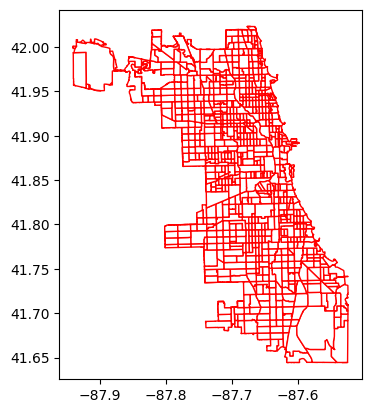

In [22]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score'}>

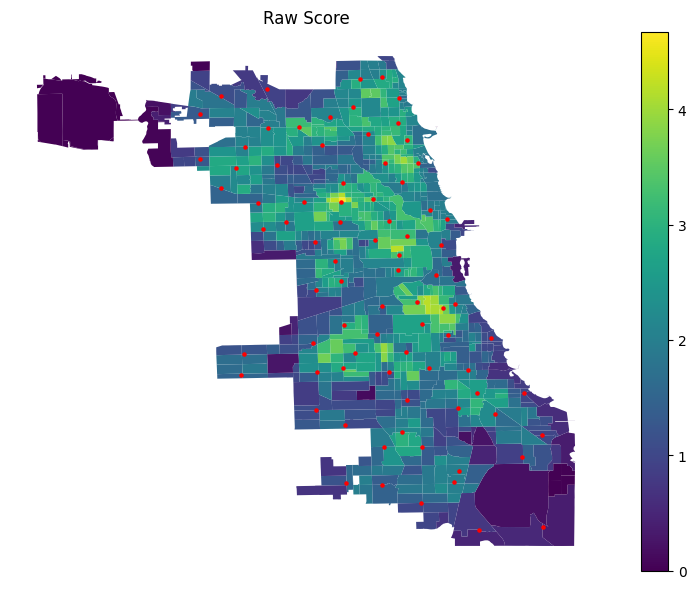

In [23]:
ax = censusTracts.plot(column = 'raw score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Raw Score Normalized'}>

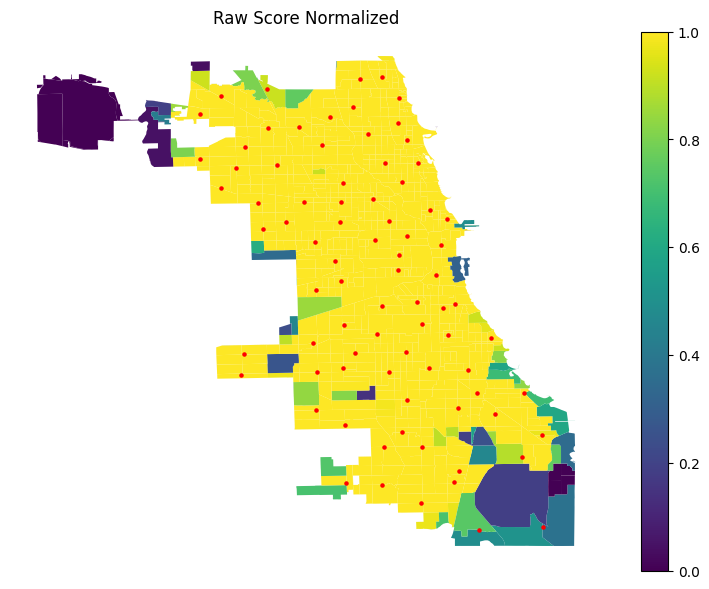

In [24]:
ax = censusTracts.plot(column = 'raw score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

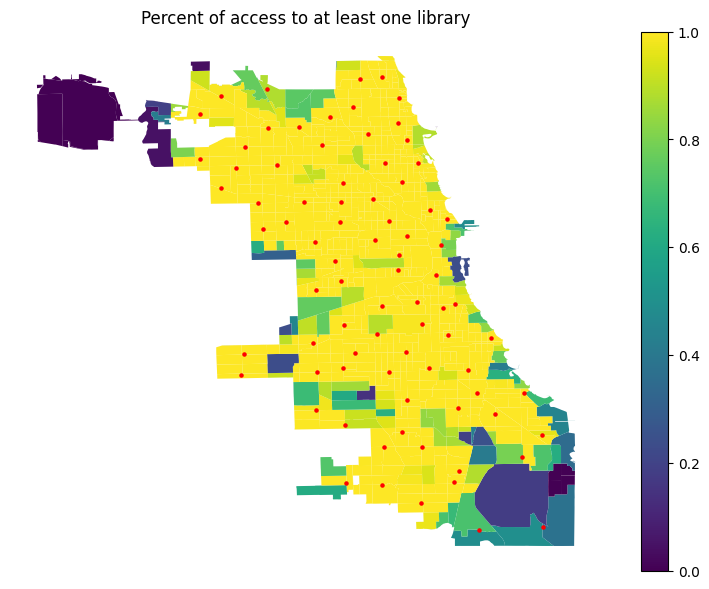

In [25]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Weighted Score'}>

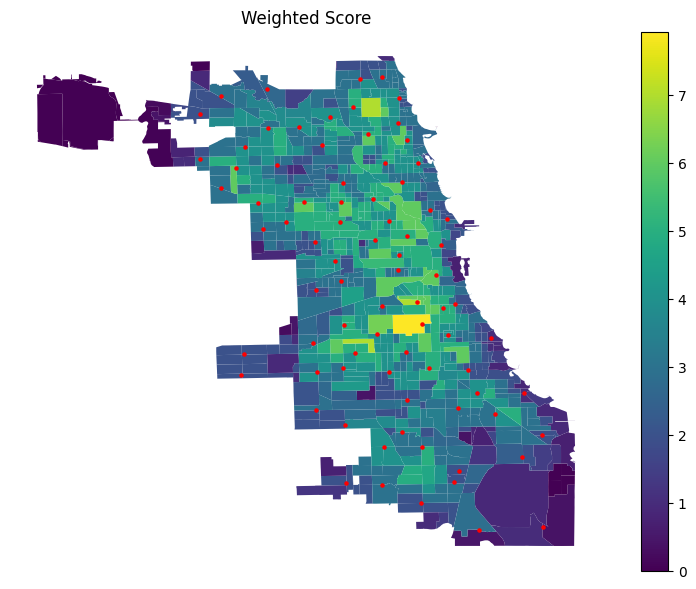

In [26]:
ax = censusTracts.plot(column = 'weighted score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Weighted Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [27]:
demographics = pd.read_csv('../data/clean/census_demos.csv')
demographics

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.052230,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,"Census Tract 8233.04, Cook County, Illinois",MULTIPOLYGON (((-87.72003618903081 41.68396731...,6316,0.060798,0.063965,0.094205,0.057948,0.056365,0.066498,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.691274, -87.719372 41.6...",4738,0.067750,0.060996,0.082946,0.063529,0.068383,0.064373,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.720431 41.698569, -87.720066 41....",5017,0.068567,0.073749,0.069962,0.042456,0.028304,0.067570,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.720752 41.702042, -87.7207...",3750,0.055200,0.114667,0.068000,0.081600,0.030933,0.027467,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.627636 41.882057, -87.627594 41....",3058,0.003924,0.003597,0.000000,0.300523,0.325049,0.050033,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.620855 41.881881, -87.620825 41....",7952,0.026157,0.038481,0.005282,0.020372,0.032193,0.095825,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.624311 41.889115, -87.6243...",8984,0.028718,0.002894,0.005677,0.000000,0.108081,0.220837,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.617537 41.893453, -87.617164 41....",5613,0.051309,0.042936,0.010868,0.012649,0.055407,0.155175,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482


In [28]:
censusTracts = censusTracts.drop(columns = ['qualifying name','geometry','polygons in census','area coverage of each polygon in census'])

In [29]:
ctm = censusTracts.merge(demographics, on = 'geoid')
ctmcopy = ctm

In [30]:
ctm.set_index('geoid', inplace = True)


In [31]:
ctm = ctm.drop(columns = ['qualifying name','geometry'])

In [32]:
corrRawScore = ctm.corrwith(ctm['raw score'])
cRaw = corrRawScore.to_frame()
cRaw=cRaw.sort_values(by = 0)
cRaw.drop(axis = 'index', index=['weighted score', 'raw score norm', 'percent covered by at least one library', 'added percentages'])

,0
Percent Workers 16+: Drove Alone,-0.409083
"Percent Workers 16+: Car, Truck, or Van",-0.388636
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.323564
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.266527
Percent Owner and Renter Occupied Housing: 4 Vehicles,-0.214485
...,...
Percent: 30 to 34 years,0.305567
Percent: 25 to 29 years,0.337036
Percent Workers 16+: Public Transportation (Includes Taxi),0.370944
number of polygons in census tract,0.676799


In [33]:
corrRawScoreN = ctm.corrwith(ctm['raw score norm'])
cRawN = corrRawScoreN.to_frame()
cRawN = cRawN.sort_values(by = 0)
cRawN.drop(axis = 'index', index=['weighted score', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Percent Workers 16+: Drove Alone,-0.336805
"Percent Workers 16+: Car, Truck, or Van",-0.311179
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.243266
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.239488
Percent Renter-Occupied Housing: 2 Vehicles,-0.226492
...,...
Percent Owner and Renter Occupied Housing: No Vehicles,0.242355
Percent Renter-Occupied Housing: No Vehicles,0.249404
Percent Workers 16+: Public Transportation (Includes Taxi),0.304728
number of polygons in census tract,0.493141


In [34]:
corrWeightedScore = ctm.corrwith(ctm['weighted score'])
cWeight = corrWeightedScore.to_frame()
cWeight = cWeight.sort_values(by = 0)
cWeight.drop(axis = 'index', index=['raw score norm', 'raw score', 'percent covered by at least one library', 'added percentages'])

,0
Percent Workers 16+: Drove Alone,-0.334187
"Percent Workers 16+: Car, Truck, or Van",-0.299552
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.263472
Percent Owner and Renter Occupied Housing: 4 Vehicles,-0.205265
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.198658
...,...
Percent: 25 to 29 years,0.239227
Percent: 30 to 34 years,0.254469
Percent Workers 16+: Public Transportation (Includes Taxi),0.287081
number of polygons in census tract,0.971323


In [35]:
corrCovPer = ctm.corrwith(ctm['percent covered by at least one library'])
cCovPer = corrCovPer.to_frame()
cCovPer = cCovPer.sort_values(by = 0)
cCovPer.drop(axis = 'index', index=['raw score norm', 'raw score', 'weighted score', 'added percentages'])

,0
Percent Workers 16+: Drove Alone,-0.343113
"Percent Workers 16+: Car, Truck, or Van",-0.317971
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.250181
Area,-0.237907
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.230627
...,...
Percent Owner and Renter Occupied Housing: No Vehicles,0.236454
Percent Renter-Occupied Housing: No Vehicles,0.240208
Percent Workers 16+: Public Transportation (Includes Taxi),0.312795
number of polygons in census tract,0.484191
